# Análise Exploratória de Dados (EDA)

## 1. Importar bibliotecas e carregar os dados pré-processados


In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
db_path = os.path.abspath(os.path.join(os.getcwd(), "..", "db"))
if db_path not in sys.path:
    sys.path.append(db_path)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_process import process_data

# Carregar dados diretamente do banco de dados usando o pipeline completo
df = process_data()
df = df.reset_index()  # Garante que 'date' seja uma coluna
# if 'date' in df.columns:
#     df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Força conversão correta
df.head()

,date,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,flow_upstream_mean,flow_upstream_max,flow_upstream_min,flow_upstream_q25,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
0,2014-01-01 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,19.369072,20.1,18.3,18.8,...,291.0,0.000000,0.010309,0.0,0.000000,0.173196,0.0,0.000000,1.000000,2014
1,2014-01-02 00:00:00+00:00,0.004124,0.2,0.0,0.0,0.0,20.271134,21.0,19.3,19.8,...,308.0,0.004124,0.084536,0.0,0.004124,0.092784,0.0,0.017213,0.999852,2014
2,2014-01-03 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,20.906383,22.3,19.3,19.8,...,302.0,0.004124,0.082474,0.0,0.004124,0.084536,0.0,0.034422,0.999407,2014
3,2014-01-04 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,17.985567,19.8,16.7,17.4,...,280.0,0.000000,0.000000,0.0,0.004124,0.082474,0.0,0.051620,0.998667,2014
4,2014-01-05 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,15.802128,16.7,15.0,15.5,...,271.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.068802,0.997630,2014


## 2. Histogramas e Séries Temporais

### **Conclusões**

- **Chuva:**  
    - Excesso de valores próximos de zero.
    - Cauda longa à direita.
    - Eventos de chuva intensa são raros.
    - Maioria dos registros corresponde a pouca ou nenhuma chuva.

- **Nível:**  
    - Distribuições mais simétricas.
    - Concentração em torno da média.
    - Reflete o nível normal do rio na maior parte do tempo.

- **Vazão:**  
    - Distribuição assimétrica.
    - Valores baixos ocorrem com mais frequência.
    - Valores altos são menos comuns.

<br>

> **Observações e Recomendações:**  
> As distribuições apresentam desbalanceamento, especialmente para chuva e vazão.  
> Recomenda-se aplicar técnicas de tratamento de dados para garantir análises mais robustas e evitar possíveis vieses.

In [2]:
def plot_histograms(df, columns, n_cols=3, bins=30, title="Histograms"):
    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        constrained_layout=True,
    )
    fig.suptitle(title, fontsize=18)
    # Ensure axes is always a flat numpy array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])
    for i, col in enumerate(columns):
        df[col].hist(ax=axes[i], bins=bins, label=col)
        axes[i].legend()
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)
    plt.show()


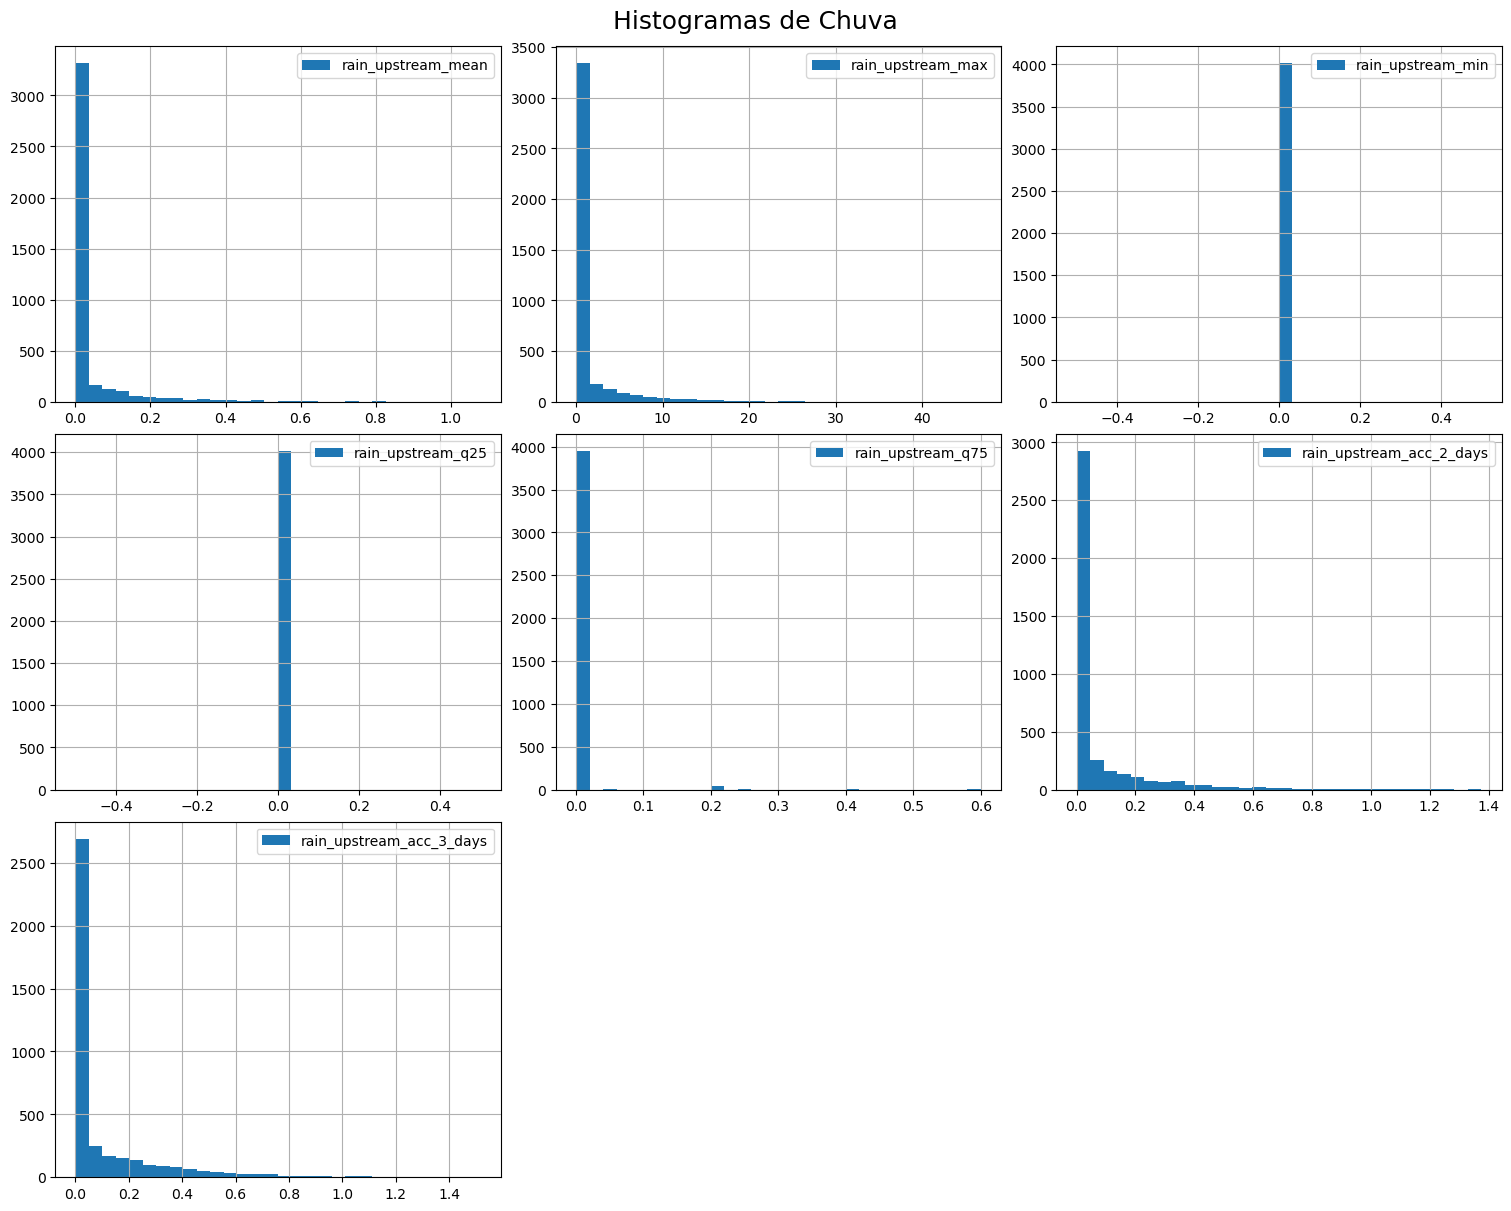

In [3]:

chuva_cols = [col for col in df.columns if col.startswith("rain_upstream")]
plot_histograms(df, chuva_cols, n_cols=3, bins=30, title="Histogramas de Chuva")

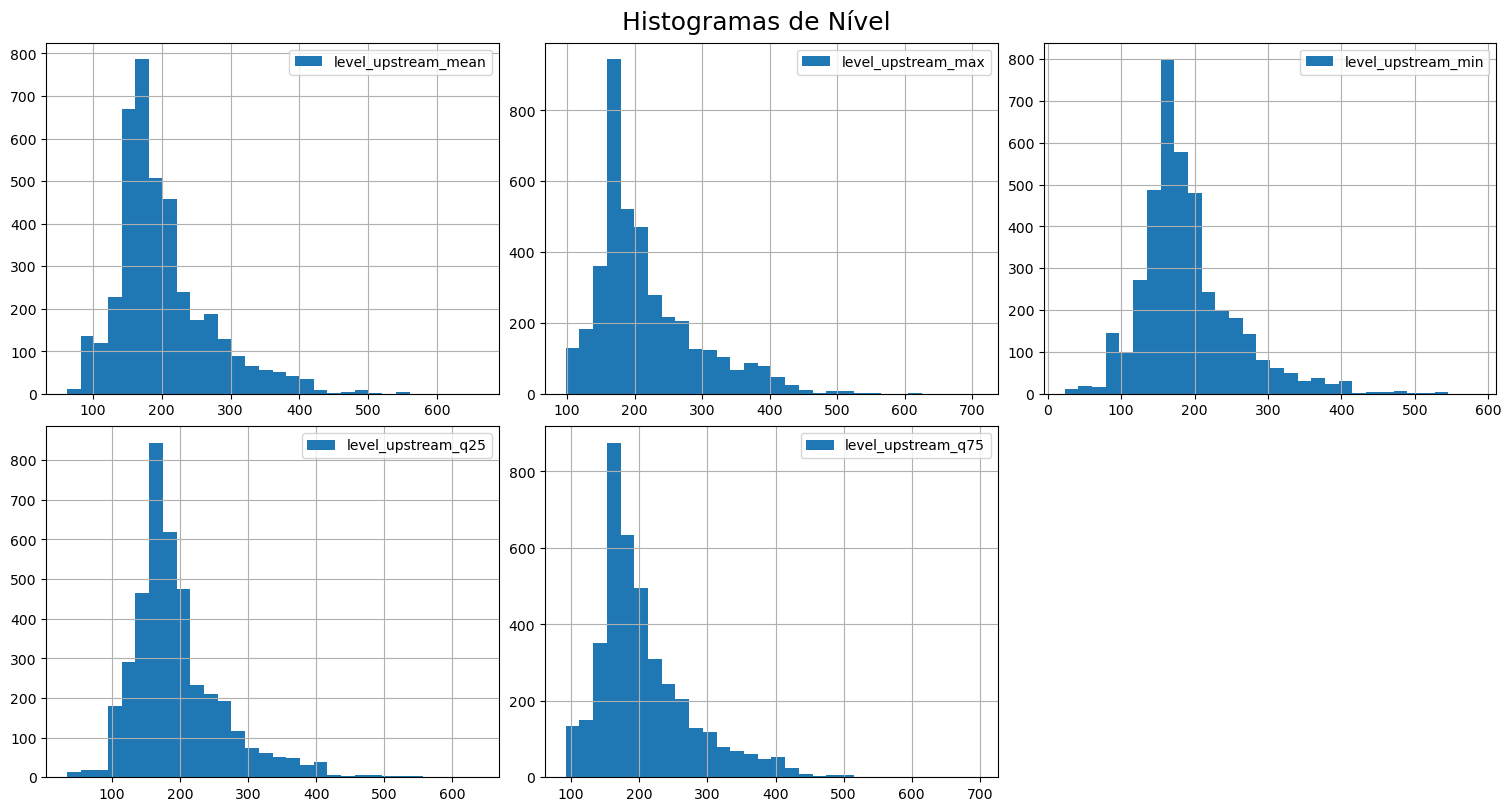

In [4]:
nivel_cols = [col for col in df.columns if col.startswith("level_upstream")]
plot_histograms(df, nivel_cols, n_cols=3, bins=30, title="Histogramas de Nível")

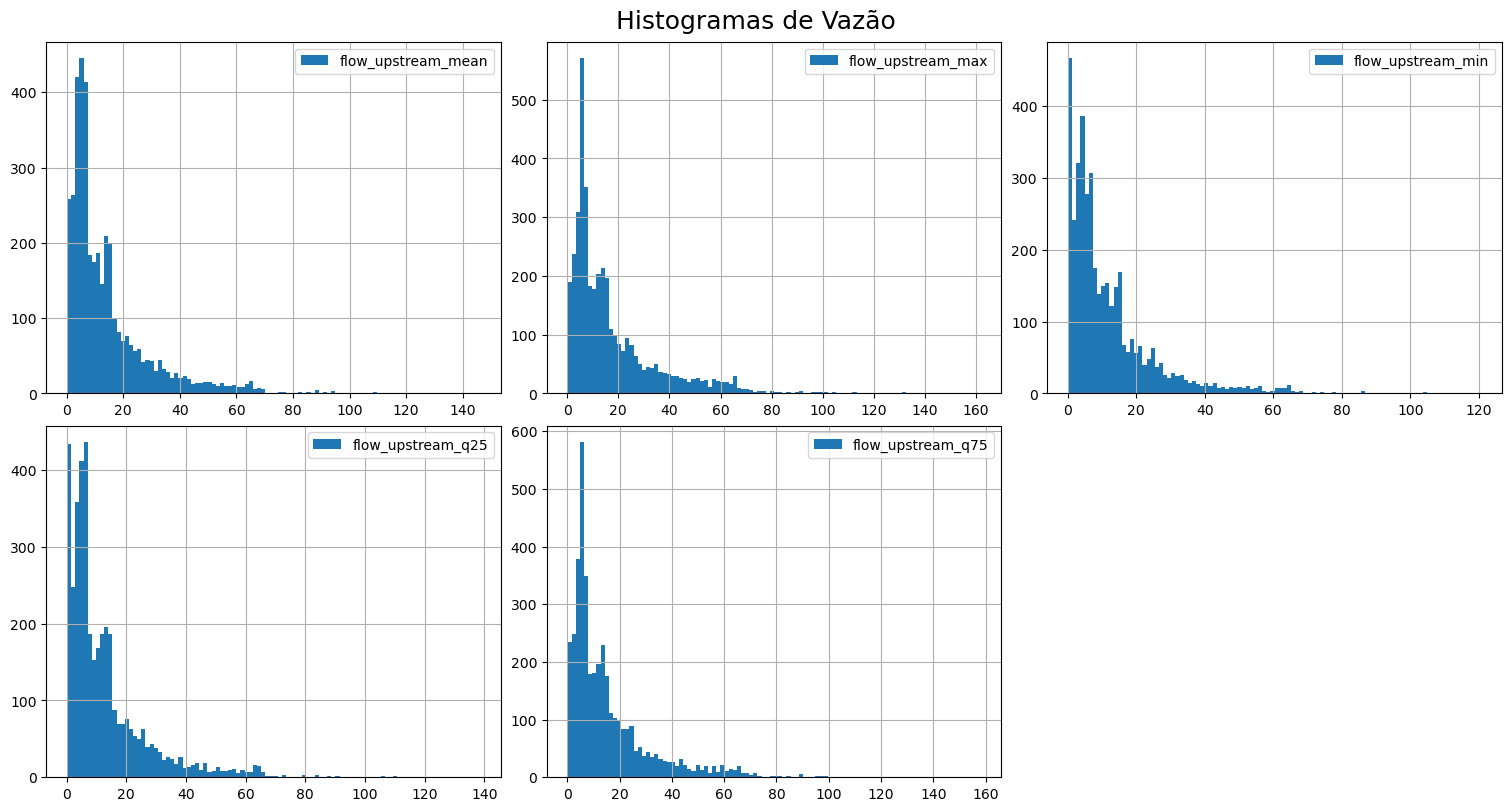

In [5]:
vazao_cols = [col for col in df.columns if "flow_upstream" in col]
plot_histograms(df, vazao_cols, n_cols=3, bins=100, title="Histogramas de Vazão")

### 2.1 Evolução Temporal do Nível do Rio e da Precipitação

Visualização conjunta do comportamento do nível do rio e da precipitação ao longo do tempo. Essa análise permite identificar tendências sazonais, padrões de resposta e possíveis eventos críticos.


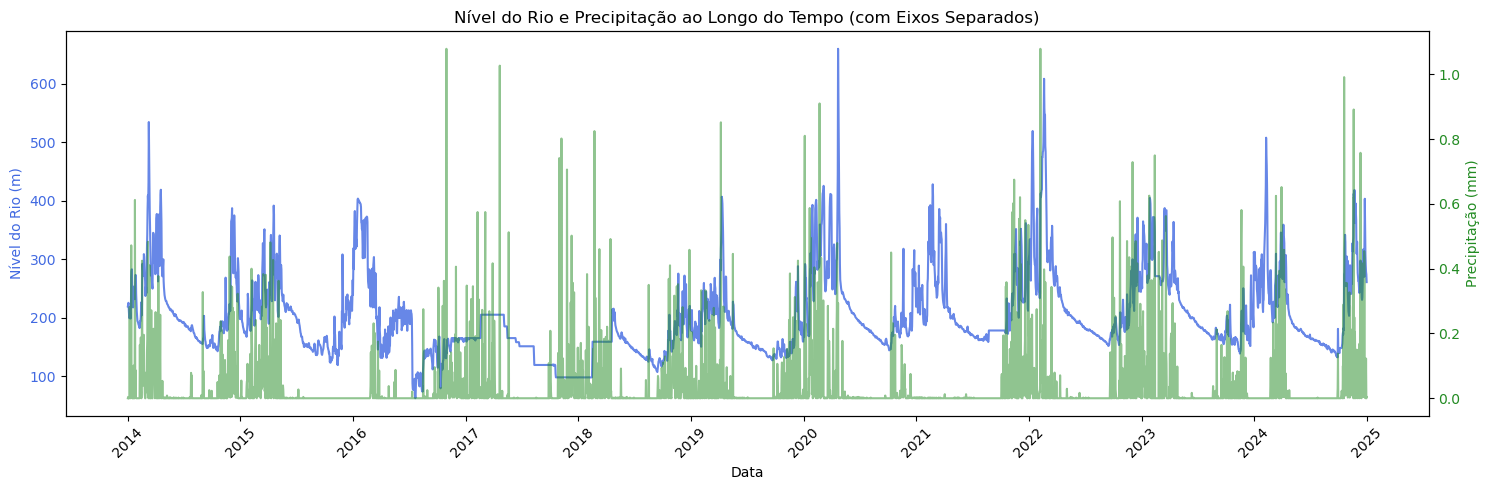

In [6]:
import matplotlib.dates as mdates

# 📈 Nível do Rio vs. Precipitação com eixos duplos e eixo X formatado
fig, ax1 = plt.subplots(figsize=(15, 5))

# Eixo Y primário (Nível do Rio)
ax1.plot(df['date'], df['level_upstream_mean'], color='royalblue', label='Nível do Rio (cm)', alpha=0.8)
ax1.set_xlabel("Data")
ax1.set_ylabel("Nível do Rio (m)", color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# Eixo Y secundário (Chuva)
ax2 = ax1.twinx()
ax2.plot(df['date'], df['rain_upstream_mean'], color='forestgreen', label='Chuva (mm)', alpha=0.5)
ax2.set_ylabel("Precipitação (mm)", color='forestgreen')
ax2.tick_params(axis='y', labelcolor='forestgreen')

# Formatação do eixo X (Data)
ax1.xaxis.set_major_locator(mdates.YearLocator())  # Marca por ano
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato: 2014, 2015...
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

plt.title("Nível do Rio e Precipitação ao Longo do Tempo (com Eixos Separados)")
fig.tight_layout()
plt.show()


### 2.2 Chuva Acumulada em 2024 com Limiar Crítico

A partir do histórico de dados de 2014 a 2024, foi calculado o 95º percentil da chuva acumulada em 72h, resultando em um **limiar crítico de aproximadamente 0.52 mm**. Esse valor representa os 5% maiores eventos de chuva acumulada registrados na série, sendo um indicativo estatístico de risco elevado de enchente.

No gráfico abaixo, observamos que vários episódios entre os meses de **novembro e dezembro de 2024** ultrapassam esse limiar, com destaque para picos superiores a 1.5 mm. Isso sugere que esses períodos concentram os maiores riscos de eventos extremos no ano, reforçando a importância de estratégias de monitoramento e alerta com base na chuva acumulada.

Esse tipo de análise pode alimentar diretamente o sistema de previsão e alerta do HydroGuard, ajudando a definir regras automáticas para disparo de notificações quando esse limiar for atingido ou superado.


Limiar crítico de chuva acumulada em 72h (95º percentil): 0.55 mm


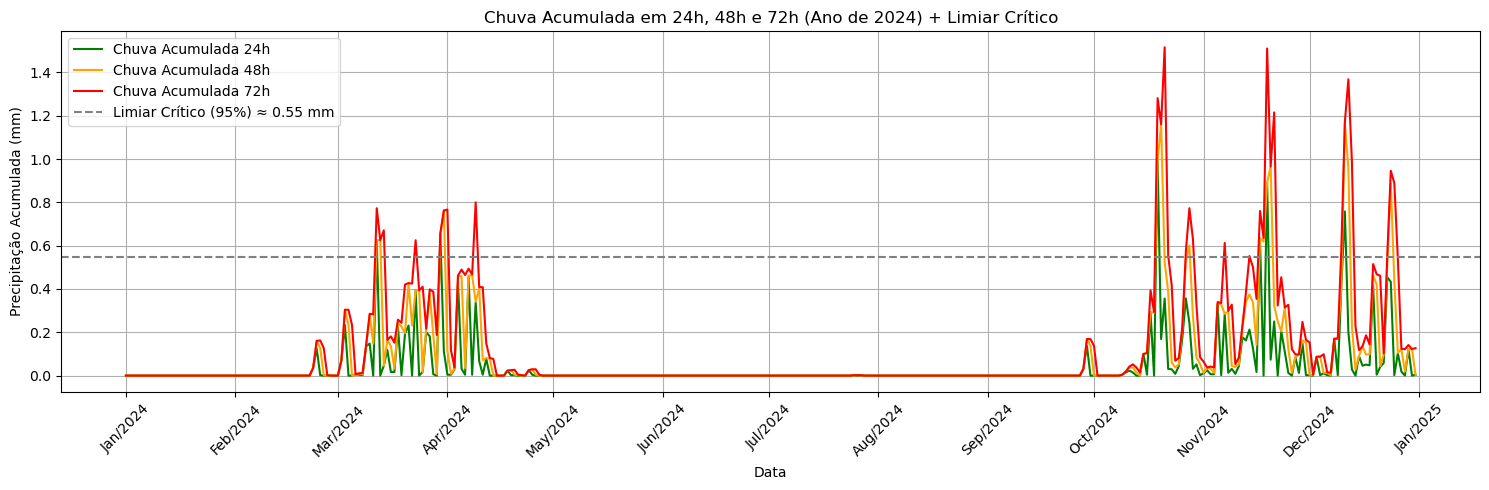

In [7]:
# 🌧️ Filtrar apenas os dados de 2024
df_2024 = df[df['date'].dt.year == 2024]

# 📌 Calcular o limiar estatístico (percentil 95 da chuva acumulada em 72h)
limiar_critico = df['rain_upstream_acc_3_days'].quantile(0.95)
print(f"Limiar crítico de chuva acumulada em 72h (95º percentil): {limiar_critico:.2f} mm")

# 📊 Plot da chuva acumulada com destaque para o limiar crítico
plt.figure(figsize=(15, 5))
plt.plot(df_2024['date'], df_2024['rain_upstream_mean'], label='Chuva Acumulada 24h', color='green')
plt.plot(df_2024['date'], df_2024['rain_upstream_acc_2_days'], label='Chuva Acumulada 48h', color='orange')
plt.plot(df_2024['date'], df_2024['rain_upstream_acc_3_days'], label='Chuva Acumulada 72h', color='red')

# 🧱 Linha horizontal indicando o limiar
plt.axhline(y=limiar_critico, color='gray', linestyle='--', label=f'Limiar Crítico (95%) ≈ {limiar_critico:.2f} mm')

plt.title("Chuva Acumulada em 24h, 48h e 72h (Ano de 2024) + Limiar Crítico")
plt.xlabel("Data")
plt.ylabel("Precipitação Acumulada (mm)")
plt.legend()
plt.grid(True)

# 🗓️ Eixo X formatado com mês e ano
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 3. Boxplots Mensais

### 3.1 Nível do Rio por Mês

Os boxplots a seguir mostram a distribuição do nível do rio para cada mês do ano, permitindo observar padrões sazonais e identificar períodos com maior variabilidade ou ocorrência de outliers.

Essa análise reforça a importância de considerar o fator temporal (ex: mês ou estação) na modelagem preditiva, uma vez que a dinâmica do rio muda significativamente ao longo do ano.


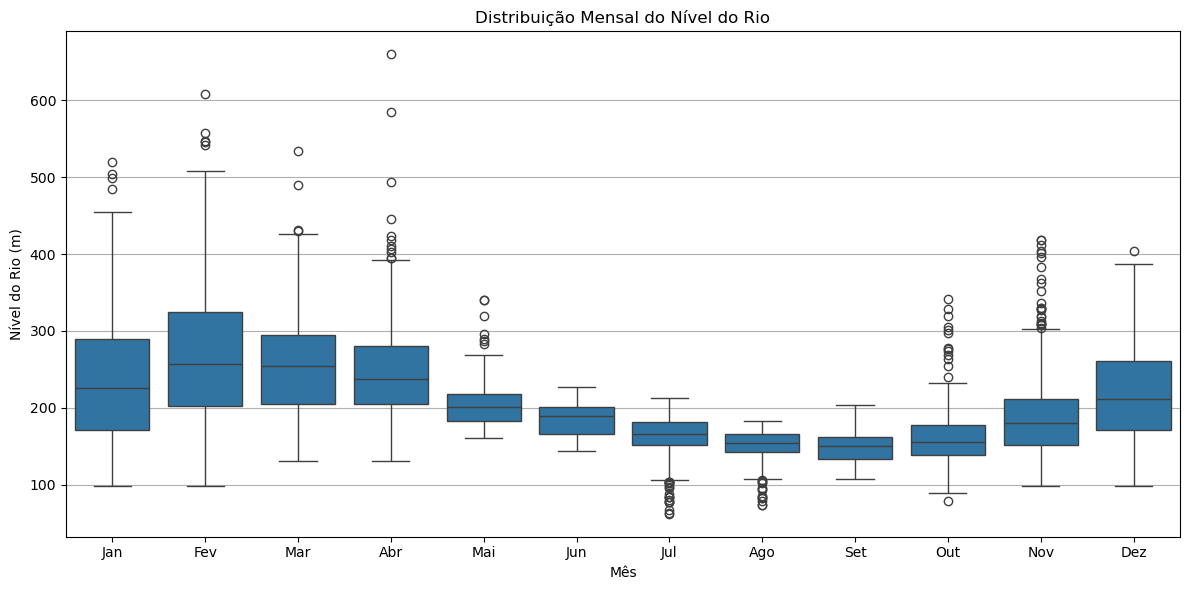

In [8]:
# 📅 Criar coluna de mês
df['month'] = df['date'].dt.month

# 🔢 Mapear nomes dos meses (opcional, deixa mais bonito)
meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}
df['mes_nome'] = df['month'].map(meses)

# 📦 Boxplot do nível do rio por mês
plt.figure(figsize=(12,6))
sns.boxplot(x='mes_nome', y='level_upstream_mean', data=df)
plt.title("Distribuição Mensal do Nível do Rio")
plt.xlabel("Mês")
plt.ylabel("Nível do Rio (m)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 3.2 Precipitação por Mês

O gráfico a seguir mostra a distribuição da precipitação média diária em cada mês, ao longo dos 10 anos da base de dados.

Comparando com o boxplot do nível do rio, é possível observar a sazonalidade da chuva e como ela se relaciona (ou não) com o comportamento do nível da água.


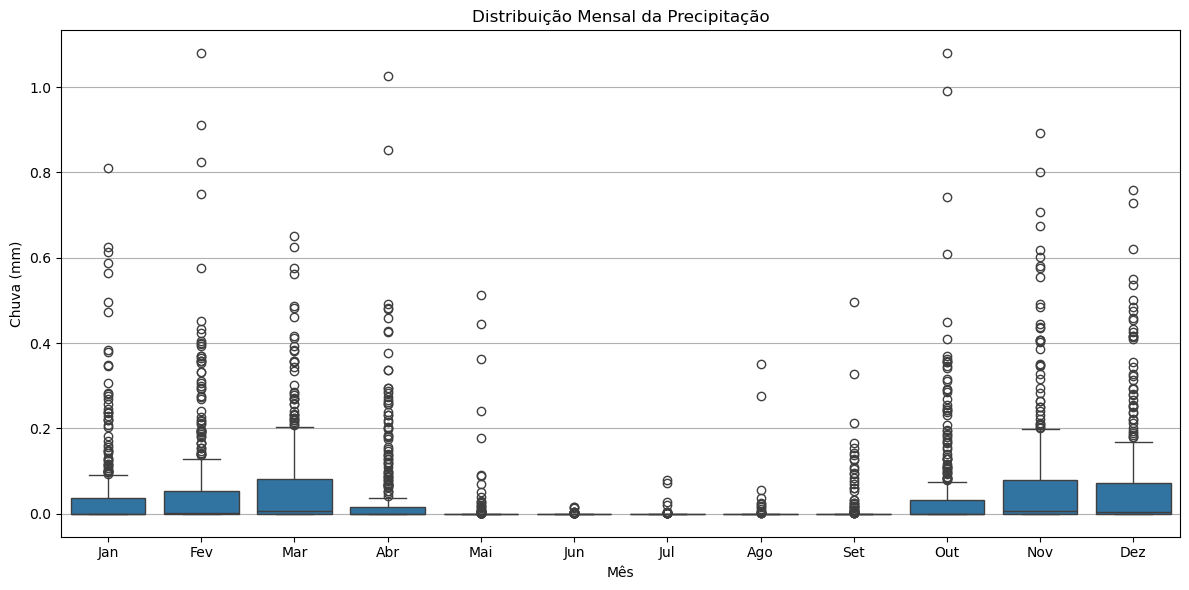

In [9]:
# 📦 Boxplot da precipitação média por mês
plt.figure(figsize=(12,6))
sns.boxplot(x='mes_nome', y='rain_upstream_mean', data=df)
plt.title("Distribuição Mensal da Precipitação")
plt.xlabel("Mês")
plt.ylabel("Chuva (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 4. Plotar Correlações

**Conclusões:**

- **Correlação entre variáveis:**  
    - Correlação fraca entre chuva e nível.
    - Correlação extremamente forte entre nível e vazão.
    - Correlação fraca entre chuva e vazão.

- **Observações e Recomendações:**  
    - A correlação entre nível e vazão é esperada, pois o nível do rio afeta diretamente a quantidade de água que flui.
    - Recomenda-se excluir variações de vazão no treinamento do modelo
    - Preferencialmente excluir a variável vazão do modelo em vez do nível, porque percebe-se que nos dados da ANA a vazão é uma variável ausente em muitas das estações, enquanto o nível é uma variável mais completa.

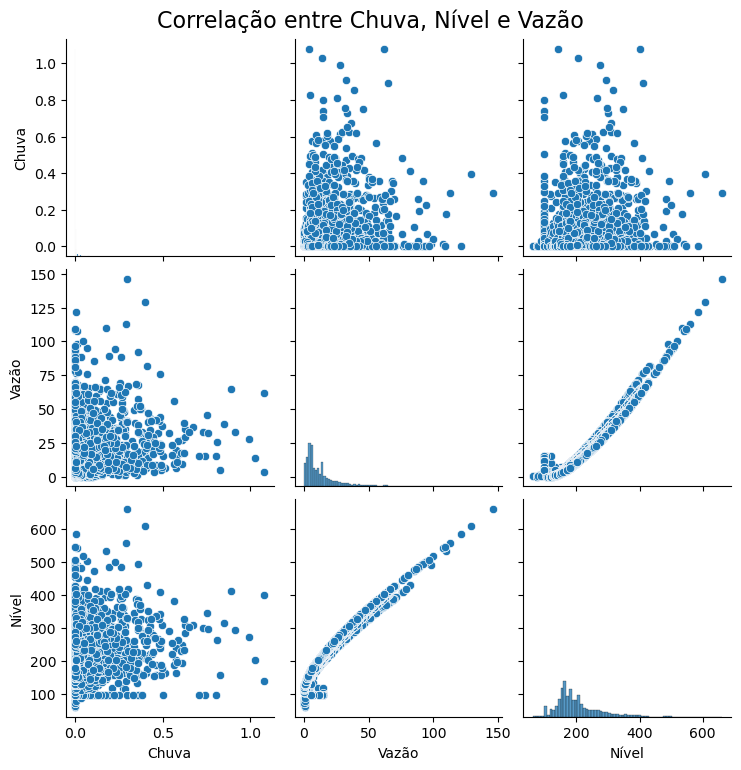

In [10]:
# Seleciona apenas as colunas de médias (apenas upstream)
mean_cols = [col for col in df.columns if "upstream_mean" in col and "acumulada" not in col]

# Mapeia os nomes das colunas para rótulos mais amigáveis
label_map = {
    "rain_upstream_mean": "Chuva",
    "level_upstream_mean": "Nível",
    "flow_upstream_mean": "Vazão"
}

# Renomeia as colunas para rótulos mais amigáveis
df_plot = df[mean_cols].rename(columns=label_map)

# Plota o pairplot com os novos rótulos
sns.pairplot(df_plot)
plt.suptitle("Correlação entre Chuva, Nível e Vazão", y=1.02, fontsize=16)
plt.show()

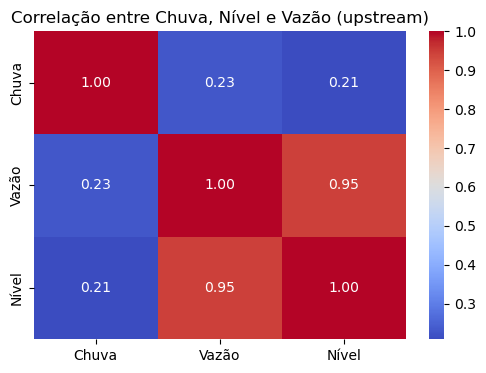

In [11]:
# Calcula a matriz de correlação entre as variáveis de média upstream
corr_matrix = df[mean_cols].corr()

# Renomeia as linhas e colunas da matriz de correlação
corr_matrix_labeled = corr_matrix.rename(index=label_map, columns=label_map)

# Plota o heatmap de correlação com os novos rótulos
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_labeled, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Chuva, Nível e Vazão (upstream)")
plt.show()

### 4.1 Correlação Defasada entre Chuva e Nível do Rio

Para entender o tempo de resposta do rio após episódios de chuva, foi analisada a correlação entre a precipitação média diária e o nível do rio com 1, 2 e 3 dias de atraso.

Observa-se que a correlação tende a aumentar levemente com o tempo de defasagem, sugerindo que os efeitos da chuva sobre o nível do rio não são imediatos, mas se acumulam em até dois ou três dias.

Esse tipo de insight é essencial para a construção de modelos preditivos baseados em séries temporais.


Correlação entre chuva e nível do rio 1 dias depois: 0.2412
Correlação entre chuva e nível do rio 2 dias depois: 0.2579
Correlação entre chuva e nível do rio 3 dias depois: 0.2527


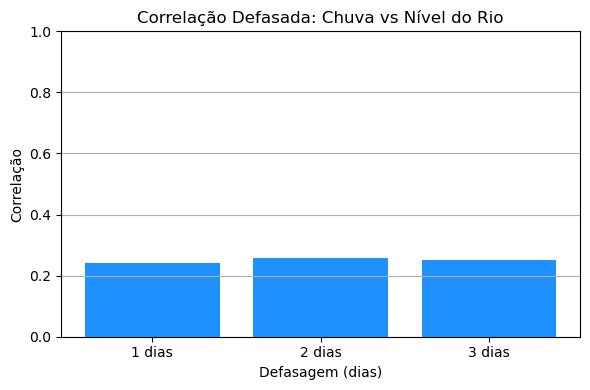

In [12]:
# 📊 Análise de correlação com defasagem (lag)
lags = [1, 2, 3]
correlacoes = {}

# Calcular correlações entre chuva e nível do rio com 1, 2 e 3 dias de atraso
for lag in lags:
    df[f'nivel_lag_{lag}d'] = df['level_upstream_mean'].shift(-lag)
    corr = df[['rain_upstream_mean', f'nivel_lag_{lag}d']].corr().iloc[0,1]
    correlacoes[f'{lag} dias'] = corr

# 📋 Exibir os valores de correlação no console
for lag, corr in correlacoes.items():
    print(f"Correlação entre chuva e nível do rio {lag} depois: {corr:.4f}")

# 📊 Gráfico de barras com os resultados
plt.figure(figsize=(6,4))
plt.bar(correlacoes.keys(), correlacoes.values(), color='dodgerblue')
plt.title("Correlação Defasada: Chuva vs Nível do Rio")
plt.ylabel("Correlação")
plt.xlabel("Defasagem (dias)")
plt.ylim(0, 1)  # ajuste se necessário
plt.grid(axis='y')
plt.tight_layout()
plt.show()
